In [25]:
import os 
import random
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import typing as t
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout, Attention,concatenate, Layer, TextVectorization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model


In [26]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [27]:
base_dir = 'C:\\Kingsley\\multimodia-hatespeech\\'
print(os.listdir(base_dir))

['4FE40520', 'bert only.ipynb', 'example1.xlsx', 'Final_dataset4.csv', 'fyp(backup).ipynb', 'fyp.ipynb', 'glove.6B.300d.txt', 'hatespeech_keywords.txt', 'image_latest(balanced)', 'image_latest(balanced)(testing)(resized)', 'image_trying_new', 'image_trying_new_resized', 'image_trying_text_new', 'img_dataset', 'img_resized', 'img_txt', 'img_txt(latest)', 'latest.xlsx', 'latestbeforeStemandLemma.xlsx', 'latestV3(balanced).xlsx', 'latestV3(removedOCRText).xlsx', 'latestV3.xlsx', 'merged(Text)(CleanedLatest)(latest).xlsx', 'merged(Text)(CleanedLatest).xlsx', 'merged(Text).xlsx', 'MMHS150K_GT.json', 'MMHS150K_readme.txt', 'model', 'modelDevelopment.ipynb', 'modelDevelopment2.ipynb', 'modelDevelopment3.ipynb', 'model_Development.py', 'multimodal-meme-classifcation(5).ipynb', 'multimodal-meme-classification (1).ipynb', 'multimodal-meme-classification(3).ipynb', 'multimodal-meme-classification(4).ipynb', 'multimodal-meme-classification.ipynb', 'multimodal_attention_model', 'multimodal_attentio

In [28]:
splits_path = os.path.join(base_dir, 'splits\\')
print(os.listdir(splits_path))

['test_ids.txt', 'train_ids.txt', 'val_ids.txt']


In [29]:
##Function to read file IDs of train, val, test splits
def read_ids(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        
        return lines
    

In [30]:
train_id_path = os.path.join(splits_path, 'train_ids.txt')
val_id_path = os.path.join(splits_path, 'val_ids.txt')
test_id_path = os.path.join(splits_path, 'test_ids.txt')

train_ids = read_ids(train_id_path)
val_ids = read_ids(val_id_path)
test_ids = read_ids(test_id_path)

In [31]:
print(f"Training data size: {len(train_ids)}")
print(f"Validation data size: {len(val_ids)}")
print(f"Testing data size: {len(test_ids)}")

Training data size: 134823
Validation data size: 5000
Testing data size: 10000


In [32]:
img_dir = os.path.join(base_dir, 'img_resized')
text_dir = os.path.join(base_dir, 'img_txt')

In [33]:
##Check if there are any missing entries from either images or text
print(f"Number of images: {len(os.listdir(img_dir))}")
print(f"Number of text files: {len(os.listdir(text_dir))}")

Number of images: 150000
Number of text files: 59252


In [34]:
##Checking the images which dont have corresponding text files
remove_extension = lambda x : x.split('.')[0]

missing_text = set(map(remove_extension, os.listdir(img_dir))) - set(map(remove_extension, os.listdir(text_dir))) 

In [35]:
missing_text = list(missing_text)

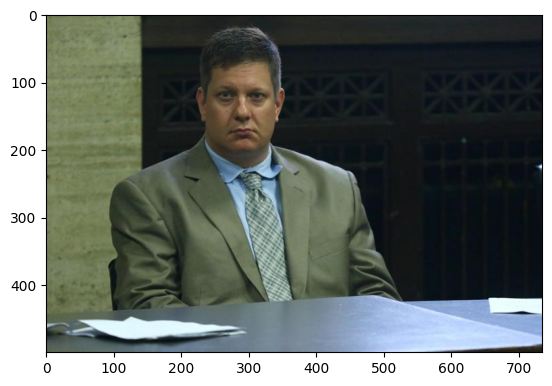

In [36]:
##Plotting an image randomly from those which dont have corresponding image texts
## Cell can be run multiple times to verify that these images don't have text
random_image = plt.imread(os.path.join(img_dir, random.choice(missing_text))+'.jpg')
plt.imshow(random_image)

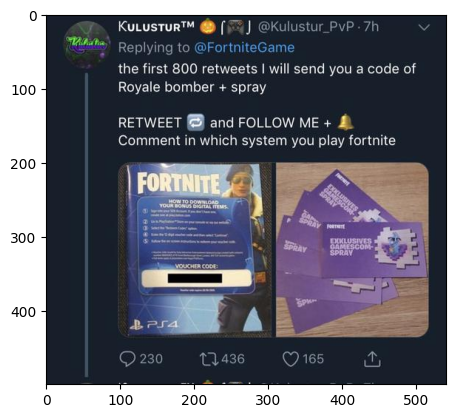

In [37]:
with_text_imgs = set(map(remove_extension, os.listdir(img_dir))).intersection(set(map(remove_extension, os.listdir(text_dir))))
with_text_imgs = list(with_text_imgs)

img_name = random.choice(with_text_imgs)
img_with_text_path = plt.imread(os.path.join(img_dir, img_name + '.jpg'))
plt.imshow(img_with_text_path)

In [38]:
print(os.path.join(text_dir, img_name + '.json'))

C:\Kingsley\multimodia-hatespeech\img_txt\1056806400494526464.json


In [39]:
with open(os.path.join(text_dir, img_name + '.json')) as f:
    d = json.load(f)
    print(d)

{'img_text': 'KULUSTURTM ●ÍM, J @Kulustur-PvP. 7h Replying to @FortniteGame the first 800 retweets I will send you a code of Royale bomber spray RETWEET and FOLLOW ME + Comment in which system you play fortnite FORTNITE ESCOM- SPRAY VOUCHER CODE: 230 436 ㅇ165 で, '}


In [40]:
def preprocess_text(text: str, encoding='utf-8') -> str:
    try:
        # Convert to lowercase
        text = text.lower()

        # Non-word character Removal
        text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
        
        # Digits Removal
        text = re.sub(r'\d', '', text)

        # Remove punctuation
        PUNCT_TO_REMOVE = string.punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # Remove stopwords
        STOPWORDS = set(stopwords.words('english'))
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # Stem words
        stemmer = SnowballStemmer(language='english')
        text = " ".join([stemmer.stem(word) for word in text.split()])

        # Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)

        # Remove HTML tags
        html_pattern = re.compile('<.*?>')
        text = html_pattern.sub(r'', text)

        return text
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError in preprocess_text: {e}")
        return ''


def preprocess_text_from_path(path : str) -> str:
    
    try:
        with open(path) as f:
            d = json.load(f)
            text = d['img_text']
        
    except Exception as e:
        text = ''
    
#     return text
    return preprocess_text(text)

In [41]:
testext1='Hey there this is a test to see if this text preprocessor is working as intended'
preprocess_text(testext1)

'hey test see text preprocessor work intend'

In [42]:
labels_path = 'C:\\Kingsley\\multimodia-hatespeech\\MMHS150K_GT.json'

In [43]:
def text_for_tokenizer(ids):
    all_texts = []
    
    
    for img_id in ids:
        
        try:
            txt_file_name = os.path.join(text_dir, img_id + '.json')

            with open(txt_file_name) as f:
                txt_dict = json.load(f)
            
            txt = txt_dict['img_text']
            processed_txt = preprocess_text(txt)
            all_texts.append(processed_txt)
            
        except Exception:
            txt = ''
            all_texts.append(txt)
            
            
    return all_texts

In [44]:
txt = text_for_tokenizer(train_ids)

In [45]:
training_texts = txt

In [46]:
max_features = 50000  #max number of tokens...the max number of unique words from our text data
sequence_length = 50 #output length..if some are not of this length they get padded

vectorization_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True)

vectorization_layer.adapt(training_texts)

In [80]:
# Create a model that uses the vectorization layer
input = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorization_layer(input)
model = tf.keras.Model(input, x)

In [81]:
# Save the model
model.save('vectorization_layer_model')

INFO:tensorflow:Assets written to: vectorization_layer_model\assets


In [47]:
def binarize_labels(labels):
    
    binarized_labels = []
    
    for label_lst in labels:
        if 0 in label_lst:
            binarized_labels.append(0)
        else:
            binarized_labels.append(1)
    
    return binarized_labels

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

def preprocess_image(image_path):
    img = plt.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Scale pixel values to [0, 1]
    return img


In [49]:
def preprocess_image(image_path):
    img = plt.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Scale pixel values to [0, 1]
    return img

def load_data(ids, batch_size=32, mode='both', shuffle=False):
    image_paths = []
    text_paths = []
    labels = []

    for data_id in ids:
        img_path = os.path.join(img_dir, data_id + '.jpg')
        text_path = os.path.join(text_dir, data_id + '.json')
        image_paths.append(img_path)
        text_paths.append(text_path)

    with open(labels_path) as f:
        label_dict = json.load(f)

    for data_id in ids:
        labels.append(label_dict[data_id]['labels'])

    num_samples = len(image_paths)
    indices = np.arange(num_samples)

    if shuffle:
        np.random.shuffle(indices)

    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = np.array(indices[start_idx:end_idx], dtype='uint8')

            batch_images = [preprocess_image(image_paths[i]) for i in batch_indices]
            batch_images = np.array([datagen.random_transform(image) for image in batch_images])  # Apply augmentation

            batch_texts = [preprocess_text_from_path(text_paths[i]) for i in batch_indices]
            batch_texts = vectorization_layer(np.array(batch_texts))

            batch_labels = binarize_labels(np.array(labels, dtype='object')[batch_indices])

            if mode == 'both':
                yield (batch_images, batch_texts), np.array(batch_labels)
            elif mode == 'img':
                yield batch_images, np.array(batch_labels)
            elif mode == 'text':
                yield batch_texts, np.array(batch_labels)
            else:
                raise Exception("Wrong mode specified")

In [66]:
train_data_generator = load_data(train_ids)

# To retrieve a batch of data:
batch_data, batch_labels = next(train_data_generator)
batch_images, batch_texts = batch_data

In [67]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Attention, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def text_feature_extractor():
    input_txt = Input(shape=(sequence_length,), dtype='int64')
    
    # Embedding Layer
    txt = Embedding(input_dim=max_features, output_dim=128)(input_txt)
    
    # First LSTM Block
    text_lstm = Bidirectional(LSTM(256, return_sequences=True))(txt)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Second LSTM Block
    text_lstm = Bidirectional(LSTM(128, return_sequences=True))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Third LSTM Block
    text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Attention Layer
    attention_layer = Attention(use_scale=True)([text_lstm, text_lstm])
    text_flatten = Flatten()(attention_layer)
    
    # Fully Connected Layers with Regularization
    fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_flatten)
    fc_layer = Dropout(0.3)(fc_layer)
    
    fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
    fc_layer = Dropout(0.3)(fc_layer)
    
    out_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
    
    return Model(inputs=input_txt, outputs=out_layer)


In [68]:
def create_image_feature_extractor(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    
    # First Convolution Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Second Convolution Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Third Convolution Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Fourth Convolution Block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Visual Attention
    visual_attention = Attention(use_scale=True)([x, x])
    visual_attention = Flatten()(visual_attention)
    
    # Fully Connected Layer with L2 Regularization
    op = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(visual_attention)
    
    feature_extractor = Model(inputs=input_tensor, outputs=op, name='image_feature_extractor')
    
    return feature_extractor

In [69]:
text_attn = text_feature_extractor()
text_attn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 128)      6400000     ['input_5[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 50, 512)     788480      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 50, 512)     2048        ['bidirectional_6[0][0]']  

In [70]:
cnn_attention = create_image_feature_extractor()
cnn_attention.summary()

Model: "image_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 224, 224, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 224, 224, 32  128        ['conv2d_8[0][0]']               
 ormalization)                  )                                           

In [71]:
def visual_attention_model():
    model = Sequential()
    
    img_fe = create_image_feature_extractor()
    
    model.add(img_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

def multimodal_attention_model():
    input_image = Input(shape=(224, 224, 3))
    input_text = Input(shape = (50), dtype='int64')  

    img_fe = create_image_feature_extractor()
    text_fe = text_feature_extractor()

    image_features = img_fe(input_image)
    text_features = text_fe(input_text)
    
    merged_features = concatenate([image_features, text_features])

    output = Dense(1, activation='sigmoid')(merged_features)

    multimodal_model = Model(inputs=[input_image, input_text], outputs=output)

    return multimodal_model

def semantic_attention_model():
    
    model = Sequential()
    
    text_fe = text_feature_extractor()
    
    model.add(text_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

Visual

In [56]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model_v2'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [57]:
visual_attention_model = visual_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22_2.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
visual_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'img')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'img')  # Replace with your validation data loader function

#Test Data Loader

test_data_loader = load_data(test_ids, mode = 'img')


# Train the model using model.fit
history = visual_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)



Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9815
Epoch 1: val_loss did not improve from 2.50431
4213/4213 [==============================] - 1268s 301ms/step - loss: 0.2238 - accuracy: 0.9815 - val_loss: 2.9809 - val_accuracy: 0.6348
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9922
Epoch 2: val_loss did not improve from 2.50431
4213/4213 [==============================] - 1243s 295ms/step - loss: 0.1203 - accuracy: 0.9922 - val_loss: 2.7302 - val_accuracy: 0.6446
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9938
Epoch 3: val_loss improved from 2.50431 to 1.89110, saving model to C:\Kingsley\multimodia-hatespeech\visual_attn_model_v2\best_modelversion22.h5
4213/4213 [==============================] - 1235s 293ms/step - loss: 0.0919 - accuracy: 0.9938 - val_loss: 1.8911 - val_accuracy: 0.6955
Epoch 4/10
4213/4213 [==============================

In [46]:
visual_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 42s 272ms/step - loss: 1.5796 - accuracy: 0.7177


[1.5795742273330688, 0.7177484035491943]

In [47]:
visual_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

312/312 [==============================] - 87s 280ms/step - loss: 1.6457 - accuracy: 0.7437


[1.645727276802063, 0.7436898946762085]

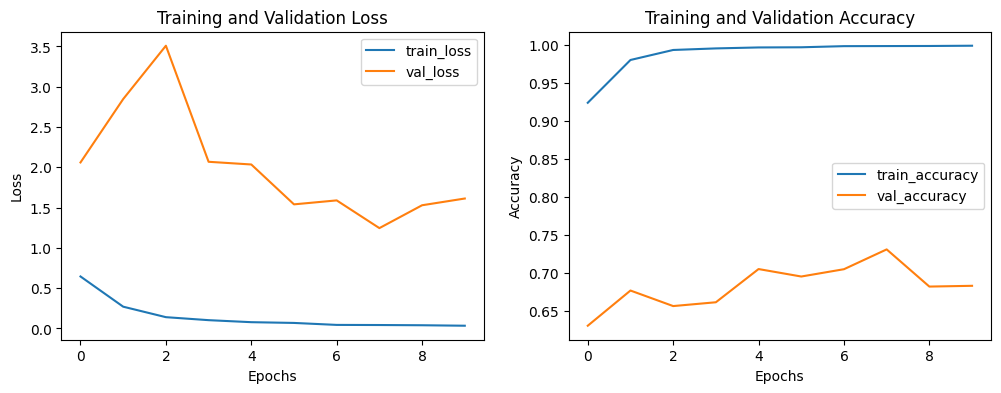

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [62]:
#save the model
visual_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model_v2\\best_modelversion22_2.h5')


Semantic 

In [73]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model_v2'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [74]:
semantic_attention_model = semantic_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22_v5.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
semantic_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [51]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

#Training data loader
train_data_loader = load_data(train_ids, mode = 'text')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'text')  # Replace with your validation data loader function

test_data_loader = load_data(test_ids, mode = 'text')

# semantic_attention_model.load_weights('/kaggle/input/lstm-modelh5/best_model.h5')

# Train the model using model.fit
history = semantic_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)


Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8482
Epoch 1: val_loss improved from inf to 0.95010, saving model to C:\Kingsley\multimodia-hatespeech\semantic_attention_model_v2\best_modelversion22.h5
4213/4213 [==============================] - 1283s 303ms/step - loss: 0.4602 - accuracy: 0.8482 - val_loss: 0.9501 - val_accuracy: 0.7576
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8531
Epoch 2: val_loss did not improve from 0.95010
4213/4213 [==============================] - 1281s 304ms/step - loss: 0.3476 - accuracy: 0.8531 - val_loss: 1.0727 - val_accuracy: 0.7576
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8535
Epoch 3: val_loss did not improve from 0.95010
4213/4213 [==============================] - 1274s 303ms/step - loss: 0.3411 - accuracy: 0.8535 - val_loss: 0.9571 - val_accuracy: 0.7576
Epoch 4/10
4213/4213 [===========================

In [52]:
semantic_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 42s 272ms/step - loss: 0.8903 - accuracy: 0.7538


[0.8902981281280518, 0.7538061141967773]

In [53]:
semantic_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

312/312 [==============================] - 88s 283ms/step - loss: 0.8181 - accuracy: 0.8008


[0.8181207776069641, 0.80078125]

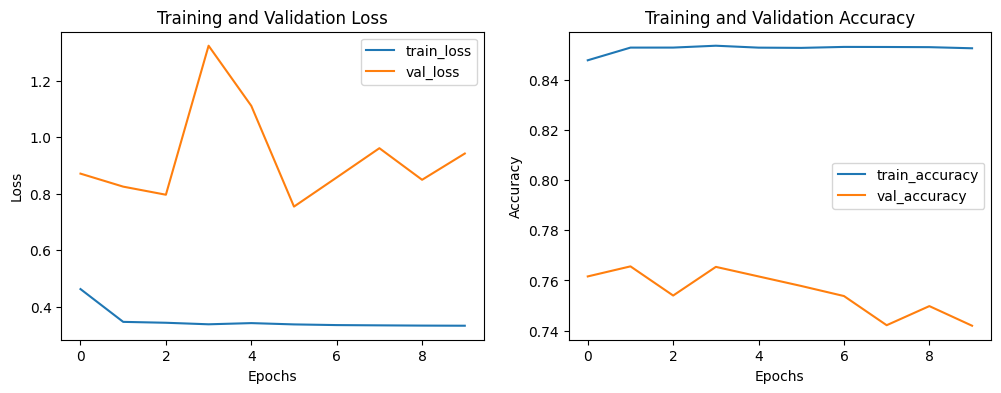

In [79]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [78]:
# save individual models

semantic_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model_v2\\best_modelversion22_v5.h5')


Multimodal

In [80]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model_v2'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [81]:
multimodal_attention_model = multimodal_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22base.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
multimodal_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
multimodal_attention_model.save_weights('multimodal_model_weights_v2.h5')

In [57]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'both')  

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'both') 

test_data_loader = load_data(test_ids, mode = 'both')

# Train the model using model.fit
history = multimodal_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)



Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.9431
Epoch 1: val_loss improved from inf to 2.21838, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model_v2\best_modelversion22.h5
4213/4213 [==============================] - 1298s 307ms/step - loss: 0.5625 - accuracy: 0.9431 - val_loss: 2.2184 - val_accuracy: 0.6272
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9836
Epoch 2: val_loss improved from 2.21838 to 2.08094, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model_v2\best_modelversion22.h5
4213/4213 [==============================] - 1299s 308ms/step - loss: 0.2257 - accuracy: 0.9836 - val_loss: 2.0809 - val_accuracy: 0.6406
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9934
Epoch 3: val_loss did not improve from 2.08094
4213/4213 [==============================] - 1285s 305ms/step - loss: 0.1196 

In [58]:
multimodal_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 42s 267ms/step - loss: 2.0549 - accuracy: 0.6338


[2.0549418926239014, 0.6338140964508057]

In [59]:
multimodal_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

312/312 [==============================] - 85s 272ms/step - loss: 1.6704 - accuracy: 0.6648


[1.6703743934631348, 0.6647636294364929]

In [ ]:
# save  models
multimodal_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model_v2\\best_modelversion22_v5.h5')

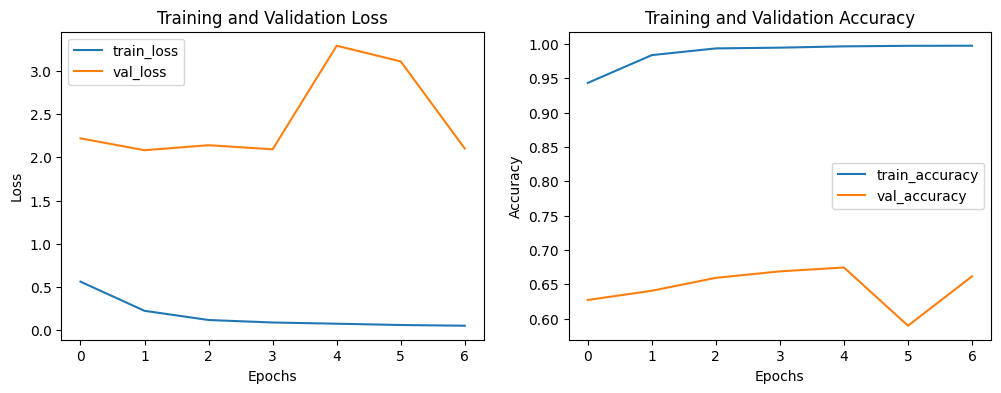

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Majority Voting (Ensemble Model)

In [61]:
def combine_predictions(predictions_list):
    """
    Combine binary predictions from multiple models using majority voting.

    Args:
        predictions_list (list): List of binary predictions from multiple models,
                                 each of shape (N, 1).

    Returns:
        list: List of combined predictions, where each element is either 0 or 1.
    """
    num_samples = len(predictions_list[0])  # Assuming all models have the same number of samples
    combined_predictions = []

    for i in range(num_samples):
        # Extract predictions for the i-th sample from all models
        sample_predictions = [model_predictions[i] for model_predictions in predictions_list]

        # Count the number of 1s and 0s
        num_ones = np.sum(sample_predictions)
        num_zeros = len(sample_predictions) - num_ones

        # Determine the majority vote
        if num_ones > num_zeros:
            combined_predictions.append(1)
        else:
            combined_predictions.append(0)

    return combined_predictions


In [62]:
comb_preds = []
true_preds = []

for num_steps in range(len(test_ids)//32):
    
    ##Dataloader being used here must have been instantiated with the 'both' argument
    
    x_batch, y_batch = next(test_data_loader)
    
    vis_preds = visual_attention_model.predict(x_batch[0])
    sem_preds = semantic_attention_model.predict(x_batch[1])
    mm_preds = multimodal_attention_model.predict(x_batch)
    
    final_preds = combine_predictions([vis_preds, sem_preds, mm_preds])
    
    comb_preds.extend(final_preds)
    true_preds.extend(list(y_batch))


1/1 [==============================] - 0s 34ms/step


In [63]:
print(classification_report(true_preds, comb_preds))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      8073
           1       0.19      0.06      0.09      1911

    accuracy                           0.77      9984
   macro avg       0.50      0.50      0.48      9984
weighted avg       0.69      0.77      0.72      9984



create all 3 models in H5 format to laod 

In [70]:
def create_semantic_attention_model():
    input_txt = Input(shape=(sequence_length,), dtype='int64')
    
    # Embedding Layer
    txt = Embedding(input_dim=max_features, output_dim=128)(input_txt)
    
    # LSTM Blocks
    text_lstm = Bidirectional(LSTM(256, return_sequences=True))(txt)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    text_lstm = Bidirectional(LSTM(128, return_sequences=True))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Attention Layer
    attention_layer = Attention(use_scale=True)([text_lstm, text_lstm])
    text_flatten = Flatten()(attention_layer)
    
    # Fully Connected Layers with Regularization
    fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_flatten)
    fc_layer = Dropout(0.3)(fc_layer)
    
    fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
    fc_layer = Dropout(0.3)(fc_layer)
    
    out_layer = Dense(1, activation='sigmoid')(fc_layer)
    
    model = Model(inputs=input_txt, outputs=out_layer)
    return model


In [68]:
def create_visual_attention_model(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    
    # Convolution Blocks
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Visual Attention
    visual_attention = Attention(use_scale=True)([x, x])
    visual_attention = Flatten()(visual_attention)
    
    # Fully Connected Layer with L2 Regularization
    op = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(visual_attention)
    
    model = Model(inputs=input_tensor, outputs=op, name='image_feature_extractor')
    return model


In [69]:
def create_multimodal_attention_model(text_sequence_length, max_features, image_input_shape=(224, 224, 3)):
    input_image = Input(shape=image_input_shape)
    input_text = Input(shape=(text_sequence_length,), dtype='int64')

    # Create feature extractors
    img_fe = create_visual_attention_model(input_shape=image_input_shape)
    text_fe = create_semantic_attention_model(sequence_length=text_sequence_length, max_features=max_features)

    # Extract features
    image_features = img_fe(input_image)
    text_features = text_fe(input_text)
    
    # Merge features
    merged_features = concatenate([image_features, text_features])

    # Final output layer
    output = Dense(1, activation='sigmoid')(merged_features)

    model = Model(inputs=[input_image, input_text], outputs=output)
    return model


In [75]:
textFeature = create_semantic_attention_model()

In [76]:
textFeature.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 50, 128)      6400000     ['input_10[0][0]']               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 50, 512)     788480      ['embedding_4[0][0]']            
 l)                                                                                               
                                                                                                  
 batch_normalization_24 (BatchN  (None, 50, 512)     2048        ['bidirectional_12[0][0]'] 

In [77]:
visualFeature = create_image_feature_extractor()

In [78]:
visualFeature.summary()

Model: "image_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 224, 224, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                           

In [ ]:

create_multimodal_attention_model()

In [73]:
visual_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model\\best_modelversion22v2.h5')
semantic_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model\\best_modelversion22_v2.h5')
multimodal_attention_model = load_model('C:\\Kingsley\multimodia-hatespeech\multimodal_attention_model\\best_modelversion22_v2.h5')

In [74]:
semantic_attention_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_16 (Functional)       (None, 64)                8149185   
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,149,250
Trainable params: 8,149,250
Non-trainable params: 0
_________________________________________________________________


In [107]:
def build_semantic_attention_model2():
    input_txt = Input(shape=(sequence_length,), dtype='int64')
    
    # Embedding Layer
    txt = Embedding(input_dim=max_features, output_dim=128)(input_txt)
    
    # First LSTM Block
    text_lstm = Bidirectional(LSTM(256, return_sequences=True))(txt)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Second LSTM Block
    text_lstm = Bidirectional(LSTM(128, return_sequences=True))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Third LSTM Block
    text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    
    # Attention Layer
    attention_layer = tf.keras.layers.Attention(use_scale=True)([text_lstm, text_lstm])
    text_flatten = Flatten()(attention_layer)
    
    # Fully Connected Layers with Regularization
    fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_flatten)
    fc_layer = Dropout(0.3)(fc_layer)
    
    fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
    fc_layer = Dropout(0.3)(fc_layer)
    
    out_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
    
    # Create the functional model
    text_feature_extractor_model = Model(inputs=input_txt, outputs=out_layer)
    
    # Create the Sequential model
    model = Sequential()
    model.add(text_feature_extractor_model)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [108]:
# Build the model
bc = build_semantic_attention_model2()

In [109]:
bc.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_12 (Functional)       (None, 64)                8152769   
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,152,834
Trainable params: 8,151,042
Non-trainable params: 1,792
_________________________________________________________________


In [110]:
# Save the model to an HDF5 file
bc.save('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model_v2\\best_modelversion22_v4.h5')


In [103]:
def build_visual_attention_model(input_shape=(224, 224, 3)):
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=input_shape))
    
    # First Convolution Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Second Convolution Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Third Convolution Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Fourth Convolution Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Flatten the output from the convolutional layers
    model.add(Flatten())
    
    # Fully Connected Layer with L2 Regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [104]:
bc1 = build_visual_attention_model()

In [105]:
bc1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_56 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_57 (Bat  (None, 112, 112, 64)    

In [106]:
# Save the model to an HDF5 file
bc1.save('C:\\Kingsley\\multimodia-hatespeech\\visual_attention_model_v2\\best_modelversion22_v4.h5')

In [99]:
def build_multimodal_attention_model(input_shape=(224, 224, 3)):
    # Image Feature Extractor
    def create_image_feature_extractor():
        input_tensor = Input(shape=input_shape)
        
        # First Convolution Block
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        # Second Convolution Block
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        # Third Convolution Block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        # Fourth Convolution Block
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        # Visual Attention
        visual_attention = Attention(use_scale=True)([x, x])
        visual_attention = Flatten()(visual_attention)
        
        # Fully Connected Layer with L2 Regularization
        op = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(visual_attention)
        
        feature_extractor = Model(inputs=input_tensor, outputs=op, name='image_feature_extractor')
        
        return feature_extractor

    # Text Feature Extractor
    def text_feature_extractor():
        input_txt = Input(shape=(sequence_length,), dtype='int64')
        
        # Embedding Layer
        txt = Embedding(input_dim=max_features, output_dim=128)(input_txt)
        
        # First LSTM Block
        text_lstm = Bidirectional(LSTM(256, return_sequences=True))(txt)
        text_lstm = BatchNormalization()(text_lstm)
        text_lstm = Dropout(0.3)(text_lstm)
        
        # Second LSTM Block
        text_lstm = Bidirectional(LSTM(128, return_sequences=True))(text_lstm)
        text_lstm = BatchNormalization()(text_lstm)
        text_lstm = Dropout(0.3)(text_lstm)
        
        # Third LSTM Block
        text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_lstm)
        text_lstm = BatchNormalization()(text_lstm)
        text_lstm = Dropout(0.3)(text_lstm)
        
        # Attention Layer
        attention_layer = Attention(use_scale=True)([text_lstm, text_lstm])
        text_flatten = Flatten()(attention_layer)
        
        # Fully Connected Layers with Regularization
        fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_flatten)
        fc_layer = Dropout(0.3)(fc_layer)
        
        fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
        fc_layer = Dropout(0.3)(fc_layer)
        
        out_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)
        
        return Model(inputs=input_txt, outputs=out_layer)

    # Build the multimodal model
    input_image = Input(shape=input_shape)
    input_text = Input(shape=(sequence_length,), dtype='int64')

    img_fe = create_image_feature_extractor()
    text_fe = text_feature_extractor()

    image_features = img_fe(input_image)
    text_features = text_fe(input_text)

    merged_features = concatenate([image_features, text_features])

    output = Dense(1, activation='sigmoid')(merged_features)

    multimodal_model = Model(inputs=[input_image, input_text], outputs=output)
    multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return multimodal_model

In [100]:
# Build the model
bc2 = build_multimodal_attention_model()

In [101]:
bc2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_22 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 image_feature_extractor (Funct  (None, 64)          3601665     ['input_21[0][0]']               
 ional)                                                                                           
                                                                                           

In [102]:
# Save the model to an HDF5 file
bc2.save('C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model_v2\\best_modelversion22_v4.h5')